Matplotlib is building the font cache; this may take a moment.


N    max_error
   8  6.903e-05
  16  1.715e-05
  32  4.308e-06
  64  1.077e-06
 128  2.692e-07
 256  6.741e-08
 512  1.696e-08
1024  4.572e-09

Observed orders (approx):
8 -> 16: 2.009
16 -> 32: 1.993
32 -> 64: 2.000
64 -> 128: 2.000
128 -> 256: 1.998
256 -> 512: 1.991
512 -> 1024: 1.891


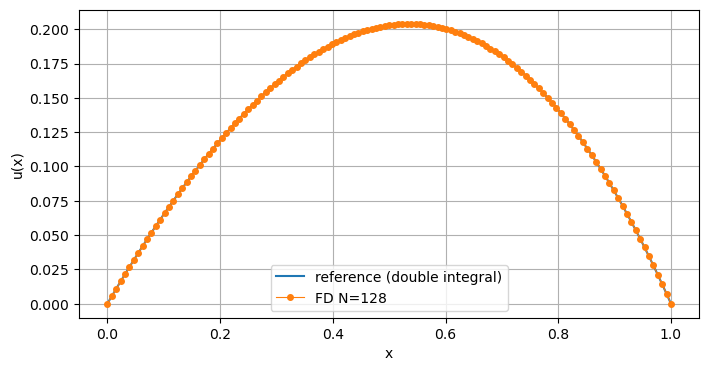

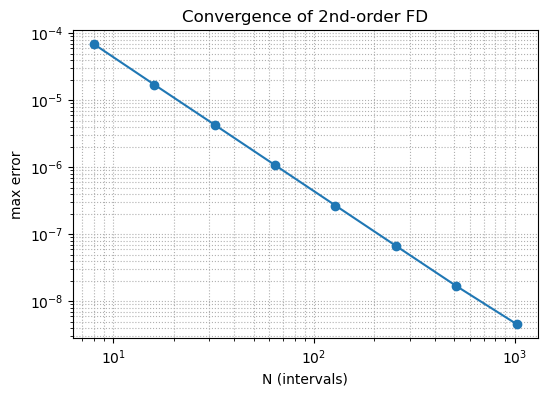

 2048  4.522e-09
 4096  4.521e-09


In [1]:
import numpy as np
import matplotlib.pyplot as plt

def f(x):
    return np.exp(np.sin(x))

# ---------- 參考解：雙重積分 (向量化複合 trapezoid) ----------
def compute_reference(M=8001):
    # M grid points on [0,1]
    x = np.linspace(0.0, 1.0, M)
    fx = f(x)
    dx = 1.0/(M-1)
    # cumulative trapezoid for I(y) = ∫_0^y f(t) dt
    cumsum = np.cumsum(fx)
    I = np.empty_like(x)
    I[0] = 0.0
    I[1:] = dx * (0.5*fx[0] + (cumsum[:-1] - fx[0]) + 0.5*fx[1:])
    # J(x) = ∫_0^x I(y) dy
    cumsumI = np.cumsum(I)
    J = np.empty_like(x)
    J[0] = 0.0
    J[1:] = dx * (0.5*I[0] + (cumsumI[:-1] - I[0]) + 0.5*I[1:])
    A = J[-1]
    u_ref = -J + x * A
    return x, u_ref

# ---------- Thomas algorithm (tridiagonal solver) ----------
def solve_tridiagonal(a, b, c, d):
    # a: lower diag (len n-1)
    # b: main diag (len n)
    # c: upper diag (len n-1)
    # d: rhs (len n)
    n = len(b)
    cp = np.empty(n-1)
    dp = np.empty(n)
    cp[0] = c[0] / b[0]
    dp[0] = d[0] / b[0]
    for i in range(1, n-1):
        denom = b[i] - a[i-1] * cp[i-1]
        cp[i] = c[i] / denom
        dp[i] = (d[i] - a[i-1] * dp[i-1]) / denom
    denom = b[-1] - a[-1] * cp[-1]
    dp[-1] = (d[-1] - a[-1] * dp[-2]) / denom
    x = np.empty(n)
    x[-1] = dp[-1]
    for i in range(n-2, -1, -1):
        x[i] = dp[i] - cp[i] * x[i+1]
    return x

# ---------- Finite difference solver (2nd order) ----------
def finite_difference_solution(N):
    h = 1.0 / N
    xs = np.linspace(0,1,N+1)
    xi = xs[1:-1]     # interior nodes
    fi = f(xi)
    n = N-1  # number of unknowns
    if n == 0:
        return xs, np.zeros_like(xs)
    b = (2.0 / h**2) * np.ones(n)       # main diagonal
    a = (-1.0 / h**2) * np.ones(n-1)    # lower
    c = (-1.0 / h**2) * np.ones(n-1)    # upper
    d = fi.copy()
    u_interior = solve_tridiagonal(a,b,c,d)
    u = np.zeros(N+1)
    u[1:-1] = u_interior
    return xs, u

# ---------- 主流程：產生 reference、FD 多組 N、比較 ----------
x_ref, u_ref = compute_reference(M=8001)

Ns = [8,16,32,64,128,256,512,1024]
errors = []
for N in Ns:
    xs, u_fd = finite_difference_solution(N)
    u_ref_on_fd = np.interp(xs, x_ref, u_ref)   # 參考解插值到 FD 節點
    err = np.max(np.abs(u_fd - u_ref_on_fd))
    errors.append(err)

print("N    max_error")
for N, e in zip(Ns, errors):
    print(f"{N:4d}  {e:.3e}")

orders = [np.log(errors[i-1]/errors[i])/np.log(2) for i in range(1,len(errors))]
print("\nObserved orders (approx):")
for i in range(len(orders)):
    print(f"{Ns[i]} -> {Ns[i+1]}: {orders[i]:.3f}")

# 繪圖：參考解與一個 FD 解
plt.figure(figsize=(8,4))
plt.plot(x_ref, u_ref, label="reference (double integral)")
xs_plot, u_fd_plot = finite_difference_solution(128)
plt.plot(xs_plot, u_fd_plot, marker='o', linewidth=0.8, markersize=4, label="FD N=128")
plt.xlabel("x"); plt.ylabel("u(x)")
plt.legend(); plt.grid(True)
plt.show()

# 收斂圖
plt.figure(figsize=(6,4))
plt.loglog(Ns, errors, marker='o')
plt.xlabel("N (intervals)"); plt.ylabel("max error")
plt.title("Convergence of 2nd-order FD")
plt.grid(True, which="both", ls=":")
plt.show()

# 檢查更大 N 是否到 plateau（選擇性）
Ns_more = [2048,4096]
for N in Ns_more:
    xs, u_fd = finite_difference_solution(N)
    u_ref_on_fd = np.interp(xs, x_ref, u_ref)
    err = np.max(np.abs(u_fd - u_ref_on_fd))
    print(f"{N:5d}  {err:.3e}")

參考解是直接以數值積分的二重積分表達式算出一個非常精細的解u_ref ，作為準確值。程式裡用複合梯形的向量化累加在很密的格點（M≈8001）上計算，以取得高準確度的參考解，之後再把參考解插值到 FD 節點得到u_ref_on_fd

另外一個解u_fd是使用二階中心差分（Finite Difference, FD）的方法來計算，最後兩個相減得到誤差max_error，中間使用Thomas演算法穩定求解tridiagonal系統，並做一系列數值的收斂實驗來驗證理論階數。

N 是在差分裡的number of subintervals

驗證：網格細化（grid refinement）與收斂率檢查

計算一系列N(intervals)（例如 8→16→32→...）並量測最大絕對誤差
∥u^(N)−u_ref∥∞。

用 log-log 圖檢查斜率，因為二階truncation error=𝑂(ℎ^2)每細化一步h 減半時誤差約變為原來的 1/4）。追蹤當N非常大時誤差是否趨於下限(plateau)，判定精度極限與其來源。

有下限的原因可能來自以下幾個：1.參考解的數值積分誤差（若你用的M太小，參考解本身不夠精確）。2.浮點四捨五入誤差（當矩陣條件數大、N 非常大時可見）。3.插值誤差（把參考解插值到 FD 節點造成小誤差；可用更密的reference grid或在內點直接用同樣格距計算參考解來避免）。

[Reference] converged in 11 iterations (N_ref=5000)
[Newton] converged in 4 iterations (N=20)
N=20: max error vs reference = 2.623e-04
[Newton] converged in 4 iterations (N=40)
N=40: max error vs reference = 6.566e-05
[Newton] converged in 4 iterations (N=80)
N=80: max error vs reference = 1.642e-05
[Newton] converged in 4 iterations (N=160)
N=160: max error vs reference = 4.105e-06
[Newton] converged in 4 iterations (N=320)
N=320: max error vs reference = 1.026e-06


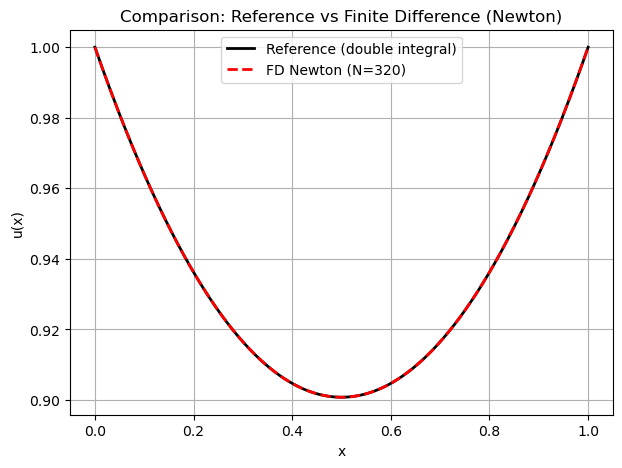

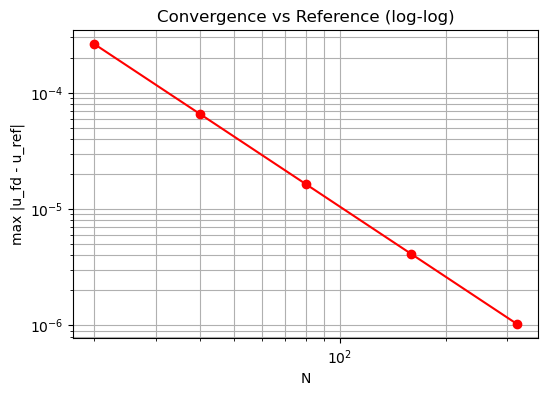

N=20→40: rate ≈ 2.00
N=40→80: rate ≈ 2.00
N=80→160: rate ≈ 2.00
N=160→320: rate ≈ 2.00


In [7]:
import numpy as np
import matplotlib.pyplot as plt

# ===============================================================
# 1. Finite difference + Newton method for nonlinear BVP
# ===============================================================
#  Equation:  -u'' + sin(u) = 0  →  u'' = sin(u)
#  Boundary:  u(0)=1, u(1)=1
# ===============================================================

def solve_fd_newton(N=80, tol=1e-10, max_iter=50):
    h = 1.0 / N
    x = np.linspace(0, 1, N + 1)
    u = np.ones(N + 1)  # initial guess (linear, satisfies BC)

    for k in range(max_iter):
        F = np.zeros(N - 1)
        # nonlinear residual
        for i in range(1, N):
            F[i - 1] = (u[i - 1] - 2 * u[i] + u[i + 1]) / h**2 - np.sin(u[i])

        # Jacobian (三對角矩陣)
        J = np.zeros((N - 1, N - 1))
        for i in range(N - 1):
            J[i, i] = -2 / h**2 - np.cos(u[i + 1])
            if i > 0:
                J[i, i - 1] = 1 / h**2
            if i < N - 2:
                J[i, i + 1] = 1 / h**2

        delta_u = np.linalg.solve(J, -F)
        u[1:N] += delta_u

        if np.linalg.norm(delta_u, np.inf) < tol:
            print(f"[Newton] converged in {k+1} iterations (N={N})")
            break
    else:
        print("Warning: Newton did not converge.")

    return x, u


# ===============================================================
# 2. Reference solution using double integration
# ===============================================================
#  u'' = sin(u) ⇒ define v = u', then
#  u'(x) = ∫₀ˣ sin(u(s)) ds
#  u(x) = 1 + ∫₀ˣ ∫₀ˢ sin(u(r)) dr ds
#  Compute by iterative refinement on a very fine grid (N_ref)
# ===============================================================

def compute_reference(N_ref=5000, tol=1e-12, max_iter=100):
    x = np.linspace(0, 1, N_ref + 1)
    h = 1.0 / N_ref
    u = np.ones(N_ref + 1)

    for k in range(max_iter):
        u_old = u.copy()
        # v(x) = ∫₀ˣ sin(u(s)) ds (trapezoidal)
        sinu = np.sin(u)
        v = np.cumsum((sinu[:-1] + sinu[1:]) / 2) * h
        v = np.concatenate(([0], v))  # ensure v(0)=0

        # u(x) = 1 + ∫₀ˣ v(s) ds
        u = 1 + np.cumsum((v[:-1] + v[1:]) / 2) * h
        u = np.concatenate(([1], u))  # BC: u(0)=1

        # 調整使得 u(1)=1
        u -= (u[-1] - 1) * x

        if np.linalg.norm(u - u_old, np.inf) < tol:
            print(f"[Reference] converged in {k+1} iterations (N_ref={N_ref})")
            break
    else:
        print("Warning: reference did not converge.")

    return x, u


# ===============================================================
# 3. Compare FD Newton vs Reference
# ===============================================================

x_ref, u_ref = compute_reference(N_ref=5000)

Ns = [20, 40, 80, 160, 320]
errors = []

for N in Ns:
    x_fd, u_fd = solve_fd_newton(N)
    u_fd_interp = np.interp(x_ref, x_fd, u_fd)
    err = np.max(np.abs(u_ref - u_fd_interp))
    errors.append(err)
    print(f"N={N}: max error vs reference = {err:.3e}")

# ===============================================================
# 4. Plot comparison and convergence
# ===============================================================

plt.figure(figsize=(7,5))
plt.plot(x_ref, u_ref, 'k', lw=2, label='Reference (double integral)')
plt.plot(x_fd, u_fd, 'r--', lw=2, label=f'FD Newton (N={Ns[-1]})')
plt.xlabel('x'); plt.ylabel('u(x)')
plt.title('Comparison: Reference vs Finite Difference (Newton)')
plt.legend(); plt.grid(True)
plt.show()

# log-log convergence plot
plt.figure(figsize=(6,4))
plt.loglog(Ns, errors, 'o-r')
plt.xlabel('N')
plt.ylabel('max |u_fd - u_ref|')
plt.title('Convergence vs Reference (log-log)')
plt.grid(True, which='both')
plt.show()

# compute convergence rate
for i in range(1, len(errors)):
    rate = np.log(errors[i-1]/errors[i]) / np.log(2)
    print(f"N={Ns[i-1]}→{Ns[i]}: rate ≈ {rate:.2f}")


參考解跟第一題一樣是直接以數值積分的二重積分表達式算出一個非常精細的解作為準確值。程式裡用複合梯形的向量化累加在很密的格點上計算，以取得高準確度的參考解

另一個解則是使用有限差分近似 (Finite Difference Discretization)，這樣每個i給出一個非線性方程式，共N−1方程式、N−1個未知數，之後使用牛頓法 (Newton’s Method) 解非線性系統。